We have moved the Study 68 code into `dissipation14e.py`. \
Now develop a new `twodimCobject` adapted to torch and the GPU.

In [12]:
import sys
print(sys.executable)

/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.10/bin/python


In [13]:
import torch
import numpy as np
import scipy
import pandas as pd
import matplotlib.pylab as plt
import time

In [14]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3
from dissipationtheory.dissipation9b import SampleModel3Jit, integrand3jit
from dissipationtheory.dissipation13e import Cmatrix_jit, KmatrixIII_jit
from dissipationtheory.dissipation13e import twodimCobject as twodimCobject_old 

In [15]:
from dissipationtheory.dissipation14e import get_device, Cmatrix, KmatrixIII

In [16]:
THIS = 'dissipation-theory--Study-68--'
figs = {}

# Test drive the new `Cmatrix` and `KmatrixIII` functions

A representative calculation from Study 67, using the new `Cmatrix` and `KmatrixIII` functions from `dissipation14e.py`.

In [17]:
device = get_device(verbose=True)

cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

sample3 = SampleModel3(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(20, 0), ""),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e19, "1/m^3"),
    z_r=ureg.Quantity(1, "nm"),
)

sample3_jit = SampleModel3Jit(**sample3.args())

loc1_nm = np.array([[ 0,  0, 20], [ 0,  0, 30]], dtype=np.float64)
loc2_nm = np.array([[ 0, 20, 20], [ 0, 30, 30]], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

omega = 1e5 * 2 * np.pi

params3_jit = {
        "integrand": integrand3jit,
        "sample": sample3_jit,
        "omega": omega,
        "location1": loc1_m,
        "location2": loc2_m,
    }

j0s = scipy.special.jn_zeros(0,100.)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {'omega': omega, 
    'omega0': params3_jit['sample'].omega0,
    'kD': params3_jit['sample'].kD,
    'es': params3_jit['sample'].epsilon_s, 
    'sj': loc1_nm, 
    'rk': loc2_nm, 
    'j0s': j0s, 
    'an': an,
    'verbose': False,
    'breakpoints': 15}

omega0 = params3_jit["sample"].omega0
kD = params3_jit["sample"].kD
es = params3_jit["sample"].epsilon_s
sj = torch.as_tensor(loc1_nm.astype(np.float32), device=device)
rk = torch.as_tensor(loc2_nm.astype(np.float32), device=device)
pts = 3000

Using MPS (Apple Silicon GPU)


In [18]:
Ctorch = Cmatrix(sj, rk)
C0jit = Cmatrix_jit(loc1_nm, loc2_nm)

print(np.allclose(C0jit, Ctorch.cpu()))

True


In [19]:
K0torch, K1torch, K2torch = KmatrixIII(omega, omega0, kD, es, sj, rk, pts, device)
K0jit, K1jit, K2jit = KmatrixIII_jit(**args)

print(
    np.allclose(K0jit, K0torch.cpu()),
    np.allclose(K1jit, K1torch.cpu()),
    np.allclose(K2jit, K2torch.cpu()),
)

True True True


# New `twodimCobject` running on the GPU (and CPU)

The main modifications to `twodimCobject` are calling `KmatrixIII` instead of `KmatrixIII_jit`.

It would be nice to keep all the matrix operations on the GPU, but unfortunately there is no torch implimentation of the singular value decomposition (SVD) routine running in the MPS backend code ([pytorch issue 125537](https://github.com/pytorch/pytorch/issues/125537)).  I need this MPS backend to use torch on my Apple M3 GPU.  

In the following code, I get the $C$ and $K_n$ matrices off the GPU and onto the CPU for the SVD step and subsequent matrix multiplications.

In `solve`, I tried to keep as many matrices as possible on the GPU, but this actually slowed things down, by a factor of ten.  I hypothesize that his slowdown is the results of sending matrices back up to the GPU after the SVD step.  So for now, determine the $C$ matrix and the $K_n$ matrices on the GPU and do all the subsequent linear algebra on the CPU.

In [20]:
class twodimCobject():

    def __init__(self, sample, device):
        """Here sample is a SampleModel1Jit, SampleModel2Jit, SampleModel3Jit, or SampleModel4Jit object."""

        self.sample = sample
        self.device = device

        self.Vr = ureg.Quantity(1, 'V')
        self.zr = ureg.Quantity(1, 'nm')

        self.results = {}
        self.results['Vts [V]'] = self.sample.cantilever.V_ts
        self.keys = ['Vts [V]']

        self.alpha = 0.0  # regularization parameter, unitless
        self.pts = 3000   # number of points used for numerical integration, unitless

        self.results['regularization parameter alpha'] = self.alpha
        self.results['integration points'] = self.pts
        self.keys += ['regularization parameter alpha', 'integration points']
        
    def print_results(self):
        
        df = pd.DataFrame.from_dict(
            obj.results,
            orient='index',
            columns=['value'])
        
        display(df)
        
    @property
    def cG(self):
        return (qe / (4 * np.pi * epsilon0 * self.Vr * self.zr)).to('dimensionless').magnitude
    
    @property
    def cGinv(self):
        return 1/self.cG
    
    def addsphere(self, h, N, M, theta_start=-np.pi/2, theta_stop=3*np.pi/2, theta_endpoint=False):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N$ image-charge points are placed along a vertical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $M$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0.  Creates two arrays: 
        (a) self.sj, the voltage-test points, and (b) self.rk, the image-charge
        points, with the coordinates in nanometers. 
        """

        # read from sample.cantilever object
        r = ureg.Quantity(self.sample.cantilever.R, 'm').to('nm').magnitude

        # convert to nm and strip units
        h = h.to('nm').magnitude
        
        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=N)
        self.rk = np.array([[0, 0, h + r + r * delta] for  delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=theta_start, stop=theta_stop, endpoint=theta_endpoint, num=M)
        self.sj = np.array([[r * np.cos(theta), 0, h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'N': N,
                     'M': M }

        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N$ = {N:d} image charges, $M$ = {M:d} test points'
        self.title2 = ''

        # Initialize these results, useful for plotting

        results = {
            'alpha': self.alpha, 
            'q': np.ones(N),
            'S': np.ones(N),
            'Sinv': np.ones(N),
            'cn': 0, 
            'V': np.zeros(M)}

        self.results.update(results)
        
    def addtip(self, h):
        """Model a cone-sphere tip above a ground plane.  The tip-sample
        separation is $h$.  The tip radius is $r$, the cone length is $L$,
        and the cone angle is $theta$ (read from self.sample.cantilever). 
        The $N_z$ image-charge points and the $N_r$ voltage test points 
        are placed following Xu and coworkers, Xu, J.; Li, J.; Li, W. 
        Calculating Electrostatic Interactions in Atomic Force Microscopy 
        with Semiconductor Samples. *AIP Advances* 2019, 9(10): 105308, 
        https://doi.org/10.1063/1.5110482."""
        
 
        # convert h to nm and strip units
        h = h.to('nm').magnitude
        
        # read from sample.cantilever object
        r = ureg.Quantity(self.sample.cantilever.R, 'm').to('nm').magnitude  # unitless, nm
        L = ureg.Quantity(self.sample.cantilever.L, 'm').to('nm').magnitude  # unitless, nm
        theta = ureg.Quantity(self.sample.cantilever.angle, 'degree')        # keep units 
        
        # convert to radians 
        thetar = theta.to('radian').magnitude

        dz = r**2/(2 * (r + h))
        d2 = h + r * (1 - np.sin(thetar))
        
        Nt = 3
        Nc = int(np.floor(np.sqrt((L - r) / dz)))
        Nz = Nt + Nc
        
        rk = np.zeros((Nz, 3))
        rk[0,:] = np.array([0, 0, np.sqrt(2 * r * h + h**2)])
        rk[1,:] = np.array([0, 0, h + r - dz])
        rk[2,:] = np.array([0, 0, h + r])
        for k in np.arange(3, Nz):
            rk[k,0] = 0
            rk[k,1] = 0
            rk[k,2] = rk[k-1,2] + dz * (2 * k - 5)
        
        self.rk = rk

        Nr = Nz
        sj = np.zeros((Nr, 3))
        sj[0,:] = np.array([0, 0, h])
        sj[1,:] = np.array([r * np.sin((np.pi/2 - thetar)/2), 0, h + r * (1 - np.cos((np.pi/2 - thetar)/2))])
        sj[2,:] = np.array([r * np.cos(thetar), 0, h + r * (1 - np.sin(thetar))])
        for k in np.arange(3, Nz):
            sj[k,2] = (rk[k,2] + rk[k-1,2])/2
            sj[k,1] = 0
            sj[k,0] = r * np.cos(thetar) + (sj[k,2] - d2) * np.tan(thetar)

        self.sj = sj
        
        # save these
        self.info = {'type': 'sphere-tipped cone', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'L [nm]': L, 
                     'theta [degree]': theta.to('degree').magnitude, 
                     'N': Nz,
                     'M': Nr}
        
        self.title1 = f'sphere-tipped cone, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, ' \
            f'$L$ = {L:0.1f} nm, $\\theta$ = {theta:0.1f}, $N_z$ = {Nz:d}, $N_r$ = {Nr:d}'
        self.title2 = ''
        
        # Initialize these results, useful for plotting

        results = {
            'alpha': self.alpha, 
            'q': np.ones(Nz),
            'S': np.ones(Nz),
            'Sinv': np.ones(Nz),
            'cn': 0, 
            'V': np.zeros(Nr)}

        self.results.update(results)

    def plot(self, N=0, M=0):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        if N == 0:
            N = self.info['N']

        if M == 0:
            M = self.info['M']
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))
        
        fig.suptitle(self.title1 + '\n' + self.title2, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rk[0:N,0], self.rk[0:N,2], 
            marker='.', c=self.results['q'][0:N], cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.results['q'][0:N])), 
            vmax=max(abs(self.results['q'][0:N])))
        ax1.scatter(self.sj[0:M,0], self.sj[0:M,2], marker='.')
        ax1.set_xlabel('$x$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')

        ax2.plot(self.rk[0:N,2], self.results['q'][0:N], '.-')
        ax2.set_xlabel('$(r_j)_{z}$ [nm]')
        ax2.set_ylabel('$q/q_{e}$')
        ax2.set_title(r''.format(), fontsize=10)

        V = self.results['V'][0:M]
        ax3.plot(1e6 * (V - np.ones_like(V)), '.-')
        ax3.set_xlabel('index')
        ax3.set_ylabel(r'$\delta V/V_0$ [ppm]')
        
        ax4.plot(self.results['S'][0:N], label='$\Lambda_k$')
        ax4.plot(self.results['Sinv'][0:N], label=r'${\mathrm{filt}}(\Lambda_k^{-1})$')
        ax4.set_xlabel('index $k$')
        ax4.set_ylabel('SVD')
        ax4.set_yscale('log')
        ax4.legend(fontsize=6, frameon=False)
        
        fig.tight_layout()
        
        return fig        
        
    def set_alpha(self, alpha):
        """Set the regularization parameter alpha.  This is a unitless number."""
        
        self.alpha = alpha
        self.results['alpha'] = alpha

    def set_integration_points(self, pts):
        """Set the number of breakpoints to use in the numerical integration."""
        
        self.pts = pts
        self.results['integration points'] = pts

    def solve(self, omega):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """
        
        sj = torch.as_tensor(self.sj.astype(np.float32), device=device)
        rk = torch.as_tensor(self.rk.astype(np.float32), device=device)
        
        Ctensor = Cmatrix(sj, rk)
        
        if self.sample.type == 3:
            
            omega0 = self.sample.omega0
            kD = self.sample.kD
            es = self.sample.epsilon_s
            
            K0tensor, K1tensor, K2tensor = KmatrixIII(omega, omega0, kD, es, sj, rk, self.pts, self.device)
            
        else:
            
            raise Exception("unknown sample type")
            
        K0 = K0tensor.cpu().numpy() 
        K1 = K1tensor.cpu().numpy()
        K2 = K2tensor.cpu().numpy()
        C = Ctensor.cpu().numpy()
        
        G0 = C - K0
        alpha = self.alpha
    
        U, S, VT = np.linalg.svd(G0, full_matrices=False) # svd not implemented yet in torch for M1
        
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T
        
        self.results['S'] = S                # unitless
        self.results['Sinv'] = np.diag(Sinv) # unitless
        self.results['cn'] = S.max()/S.min() # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])
        
        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q

        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr
                
        Vrms = np.std(V - np.ones_like(V))
        
        self.results['Vrms [ppm]'] = 1e6 * np.real(Vrms) # units of Vr        
        
        return L0, L1, L2
    
    def properties_am(self, omega_m, omega_am):
        """Compute the cantilever force and steady-state frequency shift when an 
        amplitude-modulated AC voltage is applied to the cantilever, with omega_m 
        the voltage oscillation frequency and omega_am the amplitude oscillation
        frequency. The parameter alpha is used to filter the singular values in 
        the inverse.  The results are stored in self.results, which is a dictionary
        including the following keys:
        
        - 'Fam [pN]': the steady-state force on the cantilever
        - 'Delta f am [Hz]': the steady-state frequency shift of the cantilever

        The results are in the units of the ureg module, which is a wrapper around
        the Pint unit system.`
        
        """

        # Lambda values at six frequencies: 
        #
        #   +/- omega_m
        #   +/- (omega_m + omega_am)
        #   +/- (omega_m - omega_am)

        L0a, L1a, L2a = self.solve( omega_m)
        L0b, L1b, L2b = self.solve(-omega_m)
        L0c, L1c, L2c = self.solve( omega_m + omega_am)
        L0d, L1d, L2d = self.solve(-omega_m - omega_am)
        L0e, L1e, L2e = self.solve( omega_m - omega_am)
        L0f, L1f, L2f = self.solve(-omega_m + omega_am)


        for key, val in zip(
            ['L0a', 'L1a', 'L2a',
             'L0b', 'L1b', 'L2b',
             'L0c', 'L1c', 'L2c',
             'L0d', 'L1d', 'L2d',
             'L0e', 'L1e', 'L2e',
             'L0f', 'L1f', 'L2f'],
            [L0a, L1a, L2a, 
             L0b, L1b, L2b, 
             L0c, L1c, L2c, 
             L0d, L1d, L2d, 
             L0e, L1e, L2e, 
             L0f, L1f, L2f]):

            self.results[key] = val

        # Shorthand
        
        V0 = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
        fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
        kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')
        
        # Properties

        c1 = 2 * np.pi * epsilon0 * V0**2
        Fam = c1 * np.imag(complex(0,1) * (L1a/16 + L1b/16 + L1c/64 + L1d/64 + L1e/64 + L1f/64)) 
        self.results['Fam [pN]'] = Fam.to('pN').magnitude

        c2 = - (fc * np.pi * epsilon0 * V0**2) / (kc * self.zr)
        dfam= c2 * (np.imag(complex(0,1) * (L2a/16 + L2b/16 + L2c/64 + L2d/64 + L2e/64 + L2f/64)))
        self.results['Delta f am [Hz]'] = dfam.to('Hz').magnitude

        self.keys += ['Delta f am [Hz]']

    def print_key_results(self):

        print('-'*58)
        for key in self.keys:
            print('{0:30s} {1:11.3f}    {1:+0.6e}'.format(
                key.rjust(30),
                self.results[key]))
        print('-'*58)

Compute the frequency shift for AM modulation.

In [21]:
obj1 = twodimCobject(sample3_jit, device)
obj1.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj1.set_alpha(1.0e-6)
obj1.set_integration_points(315)
obj1.solve(omega=1.0e5)

((72.39419113099575+0.031886892228200736j),
 (-0.09508153414019105-2.2178829430239965e-05j),
 (0.0014857568880799477+8.864060688021369e-07j))

In [22]:
obj1 = twodimCobject(sample3_jit, device)
obj1.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj1.set_alpha(1.0e-6)
obj1.set_integration_points(315)
obj1.properties_am(omega_m=1.0e5, omega_am = 250.)

In [23]:
obj1.print_key_results()

----------------------------------------------------------
                       Vts [V]       1.000    +1.000000e+00
regularization parameter alpha       0.000    +0.000000e+00
            integration points     315.000    +3.150000e+02
               Delta f am [Hz]      -0.172    -1.715395e-01
----------------------------------------------------------


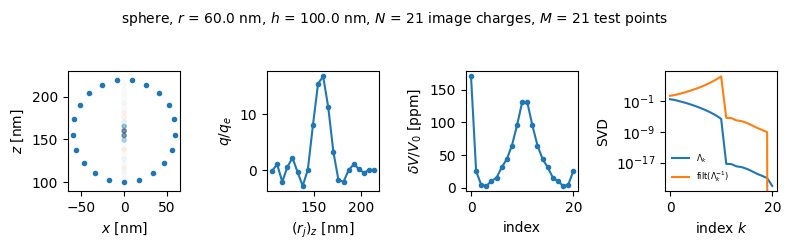

In [24]:
figs['01a'] = obj1.plot()

In [25]:
%timeit obj1.properties_am(omega_m=1.0e5, omega_am = 250.)

15.4 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Compare to compiled Python code.

In [26]:
obj2 = twodimCobject_old(sample3_jit)
obj2.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj2.set_alpha(1.0e-6)
obj2.set_breakpoints(15)
obj2.properties_am(omega_m=1.0e5, omega_am = 250.)

In [27]:
obj2.print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
             alpha       0.000    +1.000000e-06
       breakpoints      15.000    +1.500000e+01
   Delta f am [Hz]      -0.171    -1.714182e-01
--------------------------------------------------


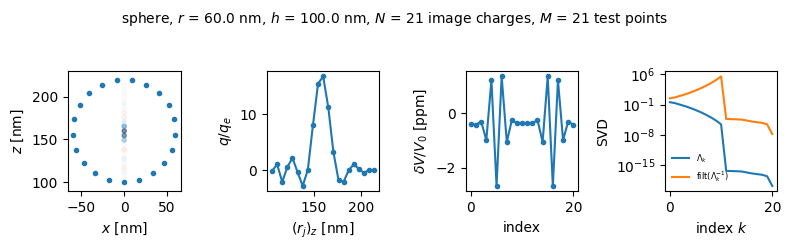

In [28]:
figs['01b'] = obj2.plot()

In [29]:
%timeit obj2.properties_am(omega_m=1.0e5, omega_am = 250.)

86.5 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The torch code shows only a modest improvement in run time, a factor of 5. \

Note that 

1. the $\delta V/V_0$ plots are very different and 
2. the frequency shifts are noticibly different too.

Compare the two computed frequency shifts. \
Write a short function to compare two numbers.

In [30]:
def compare_two(a, b):
    print('a - b = {:0.6f} and (a - b)/a = {:0.1e} = {:0.3}%'.format(
        a - b, (a - b)/a, 100 * (a - b)/a))

Print out the absolute difference and the relative difference.

In [31]:
compare_two(
    a=obj1.results['Delta f am [Hz]'],
    b=obj2.results['Delta f am [Hz]'])

a - b = -0.000121 and (a - b)/a = 7.1e-04 = 0.0707%


The difference is tolerable. \
I attribute the difference to the distinct integration schemes used by the CPU and GPU code.

# Parallel processing example code

In [21]:
import time  
import concurrent.futures
import numpy as np
import random

## Example 1

This code is copied from `multi2.py`.  \
I am surprised that it works in the Jupyter notebook1

In [24]:
def compute(seconds):
    """A simple function that sleeps for a given number of seconds."""
    
    id = random.randint(1000, 9999)
    print(f'starting process {id} for {seconds} seconds')
    time.sleep(seconds)
    return f'  finish process {id} after {seconds} seconds' 

In [25]:
print('starting 20 processes of 1 second each...')
start = time.perf_counter()

with concurrent.futures.ThreadPoolExecutor() as executor: # <== changed to ThreadPoolExecutor from ProcessPoolExecutor

    secs = np.ones(20) 
    results = [executor.submit(compute, sec) for sec in secs]

    for f in concurrent.futures.as_completed(results):
        print(f.result())

finish = time.perf_counter()  
duration = finish - start

print('\n--- summary ---')
print(f'Using concurrent.futures.ThreadPoolExecutor')
print(f'number of threads = {executor._max_workers}') 
print(f'run time = {round(duration, 2)} seconds')
print(f' speedup = {round(20/duration, 2)}x')
print('---------------')

starting 20 processes of 1 second each...
starting process 7446 for 1.0 seconds
starting process 1863 for 1.0 seconds
starting process 2873 for 1.0 seconds
starting process 1835 for 1.0 seconds
starting process 4927 for 1.0 seconds
starting process 4906 for 1.0 seconds
starting process 3845 for 1.0 seconds
starting process 5870 for 1.0 seconds
starting process 6358 for 1.0 seconds
starting process 6211 for 1.0 seconds
starting process 8021 for 1.0 seconds
starting process 6052 for 1.0 seconds
starting process 2900 for 1.0 seconds  finish process 7446 after 1.0 seconds
starting process 9434 for 1.0 seconds
starting process 2735 for 1.0 seconds
starting process 4388 for 1.0 seconds
starting process 8896 for 1.0 seconds
starting process 9474 for 1.0 seconds
starting process 9123 for 1.0 seconds
starting process 4936 for 1.0 seconds
  finish process 1863 after 1.0 seconds
  finish process 4927 after 1.0 seconds
  finish process 4906 after 1.0 seconds
  finish process 8021 after 1.0 seconds

## Example 2

This is code from `multi1.py`. \
It does not work in the Jupyter notebook.

In [26]:
print('starting 20 processes of 1 second each...')
start = time.perf_counter()

with concurrent.futures.ProcessPoolExecutor() as executor:

    secs = np.ones(20) 
    results = [executor.submit(compute, sec) for sec in secs]

    for f in concurrent.futures.as_completed(results):
        print(f.result())

finish = time.perf_counter()  
duration = finish - start

print('\n--- summary ---')
print(f'Using concurrent.futures.ProcessPoolExecutor')
print(f'number of threads = {executor._max_workers}') 
print(f'run time = {round(duration, 2)} seconds')
print(f' speedup = {round(20/duration, 2)}x')
print('---------------')

starting 20 processes of 1 second each...


Process SpawnProcess-1:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/py310/lib/python3.10/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/anaconda3/envs/py310/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'compute' on <module '__main__' (built-in)>
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
 

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

## Summary

- `concurrent.futures.ThreadPoolExecutor()` does run in Jupyter
- `concurrent.futures.ProcessPoolExecutor` does not run in Jupyter

# Revised `twodimCobject` with parallel processing

Try to dedefine the `properties_am` function to use parallel processing.

We want to wait for all the concurrent processes to finish before continuing. \
Read about how to do this on [stackoverflow](https://stackoverflow.com/questions/21143162/python-wait-on-all-of-concurrent-futures-threadpoolexecutors-futures). 

## Try 0: Rewrite the `properties_am` function

First, recode the `properties_am` function in a more loop-able way. \
Rearrange the code and remove the comments, to make it easier to edit.

In [12]:
class twodimCobject2(twodimCobject):
    
    def properties_am(self, omega_m, omega_am):

        omega_list = [ omega_m, 
                      -omega_m,
                       omega_m + omega_am,
                      -omega_m - omega_am,
                       omega_m - omega_am,
                      -omega_m + omega_am]
        
        moniker_list = ['a', 'b', 'c', 'd', 'e', 'f']
        
        L = {}
        
        for moniker, omega in zip(moniker_list, omega_list):
        
            L[moniker] = self.solve(omega)
            
        V0 = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
        fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
        kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')
        
        c1 = 2 * np.pi * epsilon0 * V0**2
        c2 = - (fc * np.pi * epsilon0 * V0**2) / (kc * self.zr)
        
        Fam = c1 * np.imag(complex(0,1) * (L['a'][1]/16 + L['b'][1]/16 +
                                           L['c'][1]/64 + L['d'][1]/64 + 
                                           L['e'][1]/64 + L['f'][1]/64)) 
        
        dfam= c2 * np.imag(complex(0,1) * (L['a'][2]/16 + L['b'][2]/16 + 
                                           L['c'][2]/64 + L['d'][2]/64 + 
                                           L['e'][2]/64 + L['f'][2]/64))

        self.results['Fam [pN]'] = Fam.to('pN').magnitude
        self.results['Delta f am [Hz]'] = dfam.to('Hz').magnitude
        self.keys += ['Delta f am [Hz]']

NameError: name 'twodimCobject' is not defined

In [29]:
obj3 = twodimCobject2(sample3_jit, device)
obj3.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj3.set_alpha(1.0e-6)
obj3.set_integration_points(315)
obj3.properties_am(omega_m=1.0e5, omega_am = 250.)

In [30]:
obj3.print_key_results()

----------------------------------------------------------
                       Vts [V]       1.000    +1.000000e+00
regularization parameter alpha       0.000    +0.000000e+00
            integration points     315.000    +3.150000e+02
               Delta f am [Hz]      -0.172    -1.715395e-01
----------------------------------------------------------


In [31]:
%timeit obj3.properties_am(omega_m=1.0e5, omega_am = 250.)

14.6 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


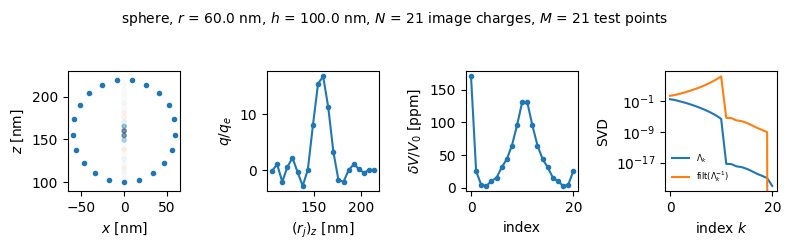

In [32]:
_ = obj3.plot()

We get the expected result, i.e. there are no major coding errors.

In [33]:
compare_two(
    a=obj1.results['Delta f am [Hz]'],
    b=obj3.results['Delta f am [Hz]'])

a - b = 0.000000 and (a - b)/a = -0.0e+00 = -0.0%


## Try 1: `concurrent.futures.ThreadPoolExecutor`

Rewrite `properties_am` implimenting parallel processing using `concurrent.futures.ThreadPoolExecutor`.

This works, but is actually slower.

Read [here](https://stackoverflow.com/questions/70700809/multiprocessing-pool-vs-multiprocessing-pool-threadpool) that "Python multithreading is less useful than you think it is. The Global Instruction Lock (GIL) means that only one thread can use the Python interpreter at a time. Since your code is pure python interpreter, nothing much is gained. Multithreading works best when your threads are waiting for external resources."

In [34]:
class twodimCobject3(twodimCobject):
    
    def properties_am(self, omega_m, omega_am):

        omega_list = [ omega_m, 
                      -omega_m,
                       omega_m + omega_am,
                      -omega_m - omega_am,
                       omega_m - omega_am,
                      -omega_m + omega_am]
        
        moniker_list = ['a', 'b', 'c', 'd', 'e', 'f']
        
        L = {}
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
        
            futures = []
            
            for omega in omega_list:
                future = executor.submit(self.solve, omega)
                futures.append(future)
        
            for moniker, future in zip(moniker_list, futures):
                L[moniker] = future.result()
                
        V0 = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
        fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
        kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')
        
        c1 = 2 * np.pi * epsilon0 * V0**2
        c2 = - (fc * np.pi * epsilon0 * V0**2) / (kc * self.zr)
        
        Fam = c1 * np.imag(complex(0,1) * (L['a'][1]/16 + L['b'][1]/16 +
                                           L['c'][1]/64 + L['d'][1]/64 + 
                                           L['e'][1]/64 + L['f'][1]/64)) 
        
        dfam= c2 * np.imag(complex(0,1) * (L['a'][2]/16 + L['b'][2]/16 + 
                                           L['c'][2]/64 + L['d'][2]/64 + 
                                           L['e'][2]/64 + L['f'][2]/64))

        self.results['Fam [pN]'] = Fam.to('pN').magnitude
        self.results['Delta f am [Hz]'] = dfam.to('Hz').magnitude
        self.keys += ['Delta f am [Hz]']

In [35]:
obj4 = twodimCobject3(sample3_jit, device)
obj4.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj4.set_alpha(1.0e-6)
obj4.set_integration_points(315)
obj4.properties_am(omega_m=1.0e5, omega_am = 250.)

In [36]:
obj4.print_key_results()

----------------------------------------------------------
                       Vts [V]       1.000    +1.000000e+00
regularization parameter alpha       0.000    +0.000000e+00
            integration points     315.000    +3.150000e+02
               Delta f am [Hz]      -0.172    -1.715395e-01
----------------------------------------------------------


In [37]:
compare_two(
    a=obj1.results['Delta f am [Hz]'],
    b=obj4.results['Delta f am [Hz]'])

a - b = 0.000000 and (a - b)/a = -0.0e+00 = -0.0%


The execution time is *longer* than 14.8 ms run time without parallel processing!

In [38]:
%timeit obj4.properties_am(omega_m=1.0e5, omega_am = 250.)

23 ms ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Try 2: `concurrent.futures.ProcessPoolExecutor`

Rewrite `properties_am` implimenting parallel processing using `concurrent.futures.ProcessPoolExecutor`. \

This fails, due to a pickling error:

    TypeError: cannot pickle 'SampleModel3Jit' object
    
Ugh! Read about his problem on [stackoverflow](https://stackoverflow.com/questions/72766345/attributeerror-cant-pickle-local-object-in-multiprocessing/72776044#72776044).

In [39]:
class twodimCobject4(twodimCobject):
    
    def properties_am(self, omega_m, omega_am):

        omega_list = [ omega_m, 
                      -omega_m,
                       omega_m + omega_am,
                      -omega_m - omega_am,
                       omega_m - omega_am,
                      -omega_m + omega_am]
        
        moniker_list = ['a', 'b', 'c', 'd', 'e', 'f']
        
        L = {}
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
        
            futures = []
            
            for omega in omega_list:
                future = executor.submit(self.solve, omega)
                futures.append(future)
        
            for moniker, future in zip(moniker_list, futures):
                L[moniker] = future.result()
                
        V0 = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
        fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
        kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')
        
        c1 = 2 * np.pi * epsilon0 * V0**2
        c2 = - (fc * np.pi * epsilon0 * V0**2) / (kc * self.zr)
        
        Fam = c1 * np.imag(complex(0,1) * (L['a'][1]/16 + L['b'][1]/16 +
                                           L['c'][1]/64 + L['d'][1]/64 + 
                                           L['e'][1]/64 + L['f'][1]/64)) 
        
        dfam= c2 * np.imag(complex(0,1) * (L['a'][2]/16 + L['b'][2]/16 + 
                                           L['c'][2]/64 + L['d'][2]/64 + 
                                           L['e'][2]/64 + L['f'][2]/64))

        self.results['Fam [pN]'] = Fam.to('pN').magnitude
        self.results['Delta f am [Hz]'] = dfam.to('Hz').magnitude
        self.keys += ['Delta f am [Hz]']

In [40]:
obj5 = twodimCobject4(sample3_jit, device)
obj5.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj5.set_alpha(1.0e-6)
obj5.set_integration_points(315)
obj5.properties_am(omega_m=1.0e5, omega_am = 250.)

TypeError: cannot pickle 'SampleModel3Jit' object

## Try 3: `multiprocessing`

The the `multiprocessing` approach. \
This approach fails with the error 

    AttributeError: Can't pickle local object 'calc.<locals>.addi'

In [41]:
import multiprocessing as mp
import os

def calc(num1, num2):

    def addi(num1, num2):
        print(num1 + num2)

    # Another local function you might have
    def addi2():
        print('hahahaha')

    m = mp.Process(target=addi, args=(num1, num2))
    m.start()

    print("here is main", os.getpid())
    m.join()

In [42]:
calc(5,6)

AttributeError: Can't pickle local object 'calc.<locals>.addi'

## Back to the books


Reading and thinking

- "Multiprocessing in Python - all about pickling" by Dawid Laszuk ([html](https://laszukdawid.com/blog/2017/12/13/multiprocessing-in-python-all-about-pickling/), posted 2017-12-13). Mentions `dill` ([pypi](https://pypi.org/project/dill/)) and `pathos` ([pypi](https://pypi.org/project/pathos/)).

- "Parallelising Python code" by Yngve Mardal Moe ([github](https://github.com/yngvem/parallelising-python); last commit in 2020). Recommends `joblib` ([github](https://github.com/joblib/joblib), [readthedocs](https://joblib.readthedocs.io/en/stable/)), but unforunately "Joblib blocks the python interpreter, so that while the other processess run, no work can be done on the mother process."

- "Running Parallel Computing on Jupyter Notebook: A tutorial on how to utilize Jupyter Notebook for parallel computing, including how to use tools like IPython parallel and Dask." by TechLatest.net ([medium](https://medium.com/@techlatest.net/running-parallel-computing-on-jupyter-notebook-a-tutorial-on-how-to-utilize-jupyter-notebook-for-c132e6a53e1d), posted 2023-07-19).  Meh. Mentions `ipyparallel` ([pypi](https://pypi.org/project/ipyparallel/), [readthedocs](https://ipyparallel.readthedocs.io/en/latest/)) and `dask` ([homepage](https://www.dask.org/), [docs](https://docs.dask.org/en/stable/), [wikipedia](https://en.wikipedia.org/wiki/Dask_(software))).

- Look at `multiprocess` ([pypi](https://pypi.org/project/multiprocess/), [readthedocs](https://multiprocess.readthedocs.io/en/latest/index.html); note the request to cite two papers if you use `multiprocess` in published work).  The multiprocess library is a fork of Python's standard multiprocessing module that uses `dill` for enhanced serialization. It is part of the `pathos` framework, which provides a more robust and flexible toolkit for parallel and heterogeneous computing.

## Try 4: `multiprocess`

Install `multiprocess`. \
In a fresh terminal running in the `dissipationtheory` directory,

    $ conda deactivate
    
then

    $ eval $(poetry env activate)
    $ poetry add multiprocess
    
and as a check

    $ python -c "import multiprocess"
    
Restart this notebook's kernel.

As a check

In [58]:
import dill
import multiprocess

In [59]:
print("running multiprocess version", multiprocess.__version__)
print("running dill version", dill.__version__)

running multiprocess version 0.70.18
running dill version 0.4.0


Now try to use `multiprocess`. \
This fails with the error 

    TypeError: cannot pickle 'SampleModel3Jit' object
    
Well this is dissapointing!

In [60]:
from multiprocess import Pool

class twodimCobject5(twodimCobject):
    
    def properties_am(self, omega_m, omega_am):

        omega_list = [ omega_m, 
                      -omega_m,
                       omega_m + omega_am,
                      -omega_m - omega_am,
                       omega_m - omega_am,
                      -omega_m + omega_am]
        
        moniker_list = ['a', 'b', 'c', 'd', 'e', 'f']
        
        L = {}
        
        p = Pool(8)
        result = p.map(self.solve, omega_list)

In [61]:
obj6 = twodimCobject5(sample3_jit, device)
obj6.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj6.set_alpha(1.0e-6)
obj6.set_integration_points(315)
obj6.properties_am(omega_m=1.0e5, omega_am = 250.)

TypeError: cannot pickle 'SampleModel3Jit' object

The solve function still works.

In [64]:
obj6.solve(omega=1.0e5)

((72.39419113099575+0.031886892228200736j),
 (-0.09508153414019105-2.2178829430239965e-05j),
 (0.0014857568880799477+8.864060688021369e-07j))

# Rewrite `twodimCobject` using non-jit sample object

Rewrite to be initiated with a `SampleModel3` instead of a `SampleModel3Jit` object. \
My hope is that this will solve the pickling problem.

Now all the `self.sample` properties have *units*. \
Modify any line calling `self.sample`.

In [85]:
class twodimCobject6():

    def __init__(self, sample, device):
        """Here sample is a SampleModel3 object."""

        self.sample = sample
        self.device = device

        self.Vr = ureg.Quantity(1, 'V')
        self.zr = ureg.Quantity(1, 'nm')

        self.results = {}
        self.results['Vts [V]'] = self.sample.cantilever.V_ts.to('V').magnitude
        self.keys = ['Vts [V]']

        self.alpha = 0.0  # regularization parameter, unitless
        self.pts = 3000   # number of points used for numerical integration, unitless

        self.results['regularization parameter alpha'] = self.alpha
        self.results['integration points'] = self.pts
        self.keys += ['regularization parameter alpha', 'integration points']
        
    def print_results(self):
        
        df = pd.DataFrame.from_dict(
            obj.results,
            orient='index',
            columns=['value'])
        
        display(df)
        
    @property
    def cG(self):
        return (qe / (4 * np.pi * epsilon0 * self.Vr * self.zr)).to('dimensionless').magnitude
    
    @property
    def cGinv(self):
        return 1/self.cG
    
    def addsphere(self, h, N, M, theta_start=-np.pi/2, theta_stop=3*np.pi/2, theta_endpoint=False):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N$ image-charge points are placed along a vertical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $M$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0.  Creates two arrays: 
        (a) self.sj, the voltage-test points, and (b) self.rk, the image-charge
        points, with the coordinates in nanometers. 
        """

        # read from sample.cantilever object
        r = self.sample.cantilever.R.to('nm').magnitude

        # convert to nm and strip units
        h = h.to('nm').magnitude
        
        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=N)
        self.rk = np.array([[0, 0, h + r + r * delta] for  delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=theta_start, stop=theta_stop, endpoint=theta_endpoint, num=M)
        self.sj = np.array([[r * np.cos(theta), 0, h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'N': N,
                     'M': M }

        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N$ = {N:d} image charges, $M$ = {M:d} test points'
        self.title2 = ''

        # Initialize these results, useful for plotting

        results = {
            'alpha': self.alpha, 
            'q': np.ones(N),
            'S': np.ones(N),
            'Sinv': np.ones(N),
            'cn': 0, 
            'V': np.zeros(M)}

        self.results.update(results)
        
    def addtip(self, h):
        """Model a cone-sphere tip above a ground plane.  The tip-sample
        separation is $h$.  The tip radius is $r$, the cone length is $L$,
        and the cone angle is $theta$ (read from self.sample.cantilever). 
        The $N_z$ image-charge points and the $N_r$ voltage test points 
        are placed following Xu and coworkers, Xu, J.; Li, J.; Li, W. 
        Calculating Electrostatic Interactions in Atomic Force Microscopy 
        with Semiconductor Samples. *AIP Advances* 2019, 9(10): 105308, 
        https://doi.org/10.1063/1.5110482."""
        
 
        # convert h to nm and strip units
        h = h.to('nm').magnitude
        
        # read from sample.cantilever object
        r = self.sample.cantilever.R.to('nm').magnitude   # unitless, nm
        L = self.sample.cantilever.L.to('nm').magnitude   # unitless, nm
        theta = self.sample.cantilever.angle.to('degree') # keep units 
        
        # convert to radians 
        thetar = theta.to('radian').magnitude

        dz = r**2/(2 * (r + h))
        d2 = h + r * (1 - np.sin(thetar))
        
        Nt = 3
        Nc = int(np.floor(np.sqrt((L - r) / dz)))
        Nz = Nt + Nc
        
        rk = np.zeros((Nz, 3))
        rk[0,:] = np.array([0, 0, np.sqrt(2 * r * h + h**2)])
        rk[1,:] = np.array([0, 0, h + r - dz])
        rk[2,:] = np.array([0, 0, h + r])
        for k in np.arange(3, Nz):
            rk[k,0] = 0
            rk[k,1] = 0
            rk[k,2] = rk[k-1,2] + dz * (2 * k - 5)
        
        self.rk = rk

        Nr = Nz
        sj = np.zeros((Nr, 3))
        sj[0,:] = np.array([0, 0, h])
        sj[1,:] = np.array([r * np.sin((np.pi/2 - thetar)/2), 0, h + r * (1 - np.cos((np.pi/2 - thetar)/2))])
        sj[2,:] = np.array([r * np.cos(thetar), 0, h + r * (1 - np.sin(thetar))])
        for k in np.arange(3, Nz):
            sj[k,2] = (rk[k,2] + rk[k-1,2])/2
            sj[k,1] = 0
            sj[k,0] = r * np.cos(thetar) + (sj[k,2] - d2) * np.tan(thetar)

        self.sj = sj
        
        # save these
        self.info = {'type': 'sphere-tipped cone', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'L [nm]': L, 
                     'theta [degree]': theta.to('degree').magnitude, 
                     'N': Nz,
                     'M': Nr}
        
        self.title1 = f'sphere-tipped cone, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, ' \
            f'$L$ = {L:0.1f} nm, $\\theta$ = {theta:0.1f}, $N_z$ = {Nz:d}, $N_r$ = {Nr:d}'
        self.title2 = ''
        
        # Initialize these results, useful for plotting

        results = {
            'alpha': self.alpha, 
            'q': np.ones(Nz),
            'S': np.ones(Nz),
            'Sinv': np.ones(Nz),
            'cn': 0, 
            'V': np.zeros(Nr)}

        self.results.update(results)

    def plot(self, N=0, M=0):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        if N == 0:
            N = self.info['N']

        if M == 0:
            M = self.info['M']
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))
        
        fig.suptitle(self.title1 + '\n' + self.title2, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rk[0:N,0], self.rk[0:N,2], 
            marker='.', c=self.results['q'][0:N], cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.results['q'][0:N])), 
            vmax=max(abs(self.results['q'][0:N])))
        ax1.scatter(self.sj[0:M,0], self.sj[0:M,2], marker='.')
        ax1.set_xlabel('$x$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')

        ax2.plot(self.rk[0:N,2], self.results['q'][0:N], '.-')
        ax2.set_xlabel('$(r_j)_{z}$ [nm]')
        ax2.set_ylabel('$q/q_{e}$')
        ax2.set_title(r''.format(), fontsize=10)

        V = self.results['V'][0:M]
        ax3.plot(1e6 * (V - np.ones_like(V)), '.-')
        ax3.set_xlabel('index')
        ax3.set_ylabel(r'$\delta V/V_0$ [ppm]')
        
        ax4.plot(self.results['S'][0:N], label='$\Lambda_k$')
        ax4.plot(self.results['Sinv'][0:N], label=r'${\mathrm{filt}}(\Lambda_k^{-1})$')
        ax4.set_xlabel('index $k$')
        ax4.set_ylabel('SVD')
        ax4.set_yscale('log')
        ax4.legend(fontsize=6, frameon=False)
        
        fig.tight_layout()
        
        return fig        
        
    def set_alpha(self, alpha):
        """Set the regularization parameter alpha.  This is a unitless number."""
        
        self.alpha = alpha
        self.results['alpha'] = alpha

    def set_integration_points(self, pts):
        """Set the number of breakpoints to use in the numerical integration."""
        
        self.pts = pts
        self.results['integration points'] = pts

    def solve(self, omega):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """
        
        sj = torch.as_tensor(self.sj.astype(np.float32), device=device)
        rk = torch.as_tensor(self.rk.astype(np.float32), device=device)
        
        Ctensor = Cmatrix(sj, rk)
        
        if self.sample.type == 3:
            
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            es = self.sample.epsilon_s.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIII(omega, omega0, kD, es, sj, rk, self.pts, self.device)
            
        else:
            
            raise Exception("unknown sample type")
            
        K0 = K0tensor.cpu().numpy() 
        K1 = K1tensor.cpu().numpy()
        K2 = K2tensor.cpu().numpy()
        C = Ctensor.cpu().numpy()
        
        G0 = C - K0
        alpha = self.alpha
    
        U, S, VT = np.linalg.svd(G0, full_matrices=False) # svd not implemented yet in torch for M1
        
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T
        
        self.results['S'] = S                # unitless
        self.results['Sinv'] = np.diag(Sinv) # unitless
        self.results['cn'] = S.max()/S.min() # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])
        
        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q

        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr
                
        Vrms = np.std(V - np.ones_like(V))
        
        self.results['Vrms [ppm]'] = 1e6 * np.real(Vrms) # units of Vr        
        
        return L0, L1, L2

This works

In [86]:
obj7 = twodimCobject6(sample3, device)
obj7.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj7.set_alpha(1.0e-6)
obj7.set_integration_points(315)
obj7.solve(omega=1.0e5)

((72.39419113099575+0.031886892228200736j),
 (-0.09508153414019105-2.2178829430239965e-05j),
 (0.0014857568880799477+8.864060688021369e-07j))

is reasonably fast

In [23]:
%timeit obj7.solve(omega=1.0e5)

2.61 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


and gets the right answer!

In [24]:
np.allclose(
    np.array(obj1.solve(omega=1.0e5)),
    np.array(obj7.solve(omega=1.0e5)))

True

# Revisit parallel processing with `multiprocess`

In [25]:
omega_m=1.0e5
omega_am = 250.

In [104]:
omega_list = [ omega_m, 
              -omega_m,
               omega_m + omega_am,
              -omega_m - omega_am,
               omega_m - omega_am,
              -omega_m + omega_am]

moniker_list = ['a', 'b', 'c', 'd', 'e', 'f']

Thins hangs!

In [27]:
# p = Pool(2)
# result = p.map(obj7.solve, omega_list)

Try using `multiprocess` on something simpler.

In [28]:
from multiprocess import Pool

In [29]:
def f(x): return x*x

p = Pool(4)
result = p.map_async(f, omega_list)

print (result.get(timeout=1))

[10000000000.0, 10000000000.0, 10050062500.0, 10050062500.0, 9950062500.0, 9950062500.0]


Change the function to solve my problem but get `TimeoutError:`.

In [30]:
# def f(x): return obj7.solve(x)
# 
# p = Pool(4)
# result = p.map_async(f, omega_list)
# 
# print (result.get(timeout=1))

Why? 

Let's tests drive `multiprocess` some more. \
Replace `multiprocessing` with `multiprocess` in the code above, and now the code runs.

In [87]:
import multiprocess as mp
import os

In [88]:
def calc(num1, num2):

    def addi(num1, num2):
        print(num1 + num2)

    # Another local function you might have
    def addi2():
        print('hahahaha')

    m = mp.Process(target=addi, args=(num1, num2))
    m.start()

    print("here is main", os.getpid())
    m.join()
    
calc(5,6)

11
here is main 26179


So `multiprocess` can indeed do more sophisticated pickling than `multiprocessing`.

Try using the above syntax. \
The `print` statement is important. \
That is how we are getting the answer back to the terminal.

In [122]:
def f(x, y): print(x*y)

m = mp.Process(target=f, args=(1e5,1e-5))
m.start()
m.join()

1.0


Why does this generate no output, but no error?

In [90]:
def f(x): print(obj7.solve(x))

m = mp.Process(target=f, args=(1e5,))
m.start()
m.join()

Go back the above simple example, and retrieve data using the queue method.  \
Put a tuple on the queue and get it.

In [91]:
def f(x, queue):
    queue.put((x, x**2))

queue = mp.Queue()

processes = {}
for key, omega in enumerate([1, 2]):
    processes[key] = mp.Process(target=f, args=(omega, queue))
    processes[key].start()

for key in processes:
    processes[key].join()
    print(queue.get())

(1, 1)
(2, 4)


Try to extend this code to `obj7.solve`. \
This code just hangs!

In [92]:
# def g(x, queue):
#    queue.put((x, obj7.solve(x)))
#
# queue = mp.Queue()

# processes = {}
# for key, omega in enumerate([1e3, 1e5]):
#     processes[key] = mp.Process(target=g, args=(omega, queue))
#     processes[key].start()
# 
# for key in processes:
#     processes[key].join()
#     print(queue.get())

**Idea**: Make `solve` a stand-alone function, instead of a member function. \
Also, strip it down to the essentials.

In [98]:
def solve(self, omega):

    sj = torch.as_tensor(self.sj.astype(np.float32), device=device)
    rk = torch.as_tensor(self.rk.astype(np.float32), device=device)

    Ctensor = Cmatrix(sj, rk)

    if self.sample.type == 3:

        omega0 = self.sample.omega0.to('Hz').magnitude
        kD = self.sample.kD.to('1/m').magnitude
        es = self.sample.epsilon_s.to('').magnitude

        K0tensor, K1tensor, K2tensor = KmatrixIII(omega, omega0, kD, es, sj, rk, self.pts, self.device)

    else:

        raise Exception("unknown sample type")

    C = Ctensor.cpu().numpy()
    
    K0 = K0tensor.cpu().numpy() 
    K1 = K1tensor.cpu().numpy()
    K2 = K2tensor.cpu().numpy()
    
    G0 = C - K0
    alpha = self.alpha

    U, S, VT = np.linalg.svd(G0, full_matrices=False) # svd not implemented yet in torch for M1

    filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
    Sinv = filt * np.diag(np.power(S, -1))
    G0inv = VT.T @ Sinv @ U.T

    IdN = np.ones(self.info['N']).T
    IdM = np.ones(self.info['M'])

    L0 = IdN @ G0inv @ IdM
    L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
    L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

    return L0, L1, L2

We call the function by passing it an object.

In [99]:
(solve(obj7, 1e3), solve(obj7, 1e5))

(((72.55339616537094+0.023923573891806882j),
  (-0.0956695789054537-5.09949776754422e-05j),
  (0.001494019179531847+1.0043624119049355e-06j)),
 ((72.39419113099575+0.031886892228200736j),
  (-0.09508153414019105-2.2178829430239965e-05j),
  (0.0014857568880799477+8.864060688021369e-07j)))

It runs about as fast as expected.

In [100]:
%timeit solve(obj7, 1e3)

2.48 ms ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


But the following code still hangs!

In [96]:
# def f(x, queue):
#     queue.put((x, solve(obj7, x)))
# 
# queue = mp.Queue()
# 
# processes = {}
# for key, omega in enumerate([1e3, 1e5]):
#     processes[key] = mp.Process(target=f, args=(omega, queue))
#     processes[key].start()
# 
# for key in processes:
#     processes[key].join()
#     print(queue.get())

This hangs too.

In [97]:
# from multiprocess import Pool
# 
# p = Pool(8)
# result = p.map(lambda x: solve(obj7, x), omega_list)

This runs.

In [102]:
import concurrent

In [113]:
def func(moniker_list, omega_list):

    with concurrent.futures.ThreadPoolExecutor() as executor:

        futures = []

        for omega in omega_list:
            future = executor.submit(solve, obj7, omega)
            futures.append(future)

        for moniker, future in zip(moniker_list, futures):
            L[moniker] = future.result()

    return L

But is no faster. \
That is, it takes about 6 times as long as running one loop. \
So there there is really no parallel processing going on.

In [119]:
%timeit func(moniker_list, omega_list)

19.8 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
%timeit solve(obj7, 1e5)

2.49 ms ± 9.86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Try again. \
The behavior is super puzzling.

The print statements show that `obj7` and `1e5` are being passsed to the function `g`.


Search Google "multiprocess.Process called function partially executed".

* On POSIX systems (Linux/macOS), the default "fork" start method can sometimes cause issues by inheriting unintended file descriptors or state.  Switch to the "spawn" start method, which starts a fresh Python interpreter process. This is the default on Windows and is a safer option that can solve certain issues.

* With certain process start methods like `fork`, a child process may inherit an unsafe state from the parent, especially when using hardware accelerators like GPUs. This is known as a "poison fork" and can cause crashes.


If the start method is "fork", then the function `solve(obj, x)` is not being executed, nor is the function `g` throwing an error.  If the start method is "spawn" then the function `g` throws an error 

    NameError: name 'os' is not defined
    

In [296]:
import traceback
import os

In [297]:
def worker(obj, x, queue):
    
    print("pid =", os.getpid())
    print("> x =", x)
    print("> r =", obj.sample.cantilever.R.to('nm').magnitude, "nm")
    
    try:
        ans = solve(obj, x)
        queue.put((x, ans))
    except Exception as e:
        queue.put((e, traceback.format_exc()))
    finally:
        print("worker finished (maybe with an error).")

Run using the "fork" method.

In [301]:
mp.set_start_method('fork', force=True) # you need the force statement

In [302]:
print("start method =", mp.get_start_method())

q = mp.Manager().Queue() # still fails with q = mp.Queue()

p = mp.Process(target=worker, args=(obj7, 1e5, q))

p.start()
print("started")

p.join()
print("joined")

if not q.empty():
    result = q.get()
    if isinstance(result, tuple):
        error, tb = result
        print(f"child process encountered an error: {error}")
        print("traceback:")
        print(tb)
    else:
        print(f"child process returned: {result}")
else:
    print("queue is empty")

start method = fork
pid = 29395
> x = 100000.0
> r = 60 nm
started
joined
queue is empty


Run using the "spawn" method.

In [303]:
mp.set_start_method('spawn', force=True) # you need the force statement

In [304]:
print("start method =", mp.get_start_method())

q = mp.Manager().Queue() # still fails with q = mp.Queue()

p = mp.Process(target=worker, args=(obj7, 1e5, q))

p.start()
print("started")

p.join()
print("joined")

if not q.empty():
    result = q.get()
    if isinstance(result, tuple):
        error, tb = result
        print(f"child process encountered an error: {error}")
        print("traceback:")
        print(tb)
    else:
        print(f"child process returned: {result}")
else:
    print("queue is empty")

start method = spawn
started


Process Process-243:
Traceback (most recent call last):
  File "/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.10/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.10/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/2j/0f14g9js2bx0k8yr1_tgvkmc0000gp/T/ipykernel_26179/508783367.py", line 3, in worker
NameError: name 'os' is not defined


joined
queue is empty


# New `twodimObjectExperimental` defined in `dissipation14e.py`

You can restart the kernel and run the code from here.

In [1]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3
from dissipationtheory.dissipation14e import get_device, twodimCobjectExperimental

In [2]:
device = get_device(verbose=True)

cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

sample3 = SampleModel3(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(20, 0), ""),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e19, "1/m^3"),
    z_r=ureg.Quantity(1, "nm"),
)

device = get_device()

Using MPS (Apple Silicon GPU)


In [3]:
obj7 = twodimCobjectExperimental(sample3, device)
obj7.addsphere(ureg.Quantity(100,'nm'), 21, 21)
obj7.set_alpha(1.0e-6)
obj7.set_integration_points(21 * 15)
obj7.solve(omega=1.0e5)

((72.39419113099575+0.031886892228200736j),
 (-0.09508153414019105-2.2178829430239965e-05j),
 (0.0014857568880799477+8.864060688021369e-07j))

In [4]:
%timeit obj7.solve(omega=1.0e5)

2.61 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now test three different parallel processing codes. \
This first mockup runs rapidly. 

In [5]:
obj7.properties_blds_mockup1(['a', 'b', 'c'], [1.0e4, 1.0e5, 1.0e6])

{'a': ((72.47301948070526+0.08935557612630873j),
  (-0.0954033111661888-0.00016916492738707907j),
  (0.001489519391292049+3.558274066672862e-06j)),
 'b': ((72.39419113099575+0.031886892228200736j),
  (-0.09508153414019105-2.2178829430239965e-05j),
  (0.0014857568880799477+8.864060688021369e-07j)),
 'c': ((72.3331320732832+0.005989109758473887j),
  (-0.09484888634886823+7.934507055341178e-06j),
  (0.001482287421499251-3.6600411438582336e-08j))}

But no faster than expected, about 8 ms for three frequencies. \
So there is no parallel processing speedup.

In [6]:
%timeit obj7.properties_blds_mockup1(['a', 'b', 'c'], [1.0e4, 1.0e5, 1.0e6])

8 ms ± 68.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This works, but is hopelessly slow, about 5 seconds for one frequency!

In [7]:
obj7.properties_blds_mockup2(omega=1.0e5)

(100000.0,
 ((72.39419113099575+0.031886892228200736j),
  (-0.09508153414019105-2.2178829430239965e-05j),
  (0.0014857568880799477+8.864060688021369e-07j)))

In [8]:
%timeit obj7.properties_blds_mockup2(omega=1.0e5)

5.02 s ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This works, but is also hopelessly slow, about 6.5 seconds for three frequencies.

In [9]:
obj7.properties_blds_mockup3(['a', 'b', 'c'], [1.0e4, 1.0e5, 1.0e6])

{'a': ((72.47301948070526+0.08935557612630873j),
  (-0.0954033111661888-0.00016916492738707907j),
  (0.001489519391292049+3.558274066672862e-06j)),
 'b': ((72.39419113099575+0.031886892228200736j),
  (-0.09508153414019105-2.2178829430239965e-05j),
  (0.0014857568880799477+8.864060688021369e-07j)),
 'c': ((72.3331320732832+0.005989109758473887j),
  (-0.09484888634886823+7.934507055341178e-06j),
  (0.001482287421499251-3.6600411438582336e-08j))}

In [10]:
%timeit obj7.properties_blds_mockup3(['a', 'b', 'c'], [1.0e4, 1.0e5, 1.0e6])

6.33 s ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


::: {.content-hidden when-format="html"}

# Save the figures

In [32]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-68.ipynb && open dissipation-theory--Study-68.html
    
:::